In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import nltk
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from num2words import num2words 

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv('Data_sets/data1_training.csv')

In [4]:
df

,sentiment,text
0,0,awww bummer shoulda got david carr third day
1,0,upset cannot update facebook texting might cry result school today also blah
2,0,dived many times ball managed save rest go bounds
3,0,whole body feels itchy like fire
4,0,behaving mad cannot see
...,...,...
1332077,1,mmmm sounds absolutely perfect schedule full tears eyes lay bed sunday ugh
1332078,1,yeah work better waiting end wonder tears eyes keep good blog
1332079,1,cool hear old walt interviews
1332080,1,happy th birthday boo alll time tupac amaru shakur


In [5]:
X = df['text']  # Features (text)
y = df['sentiment']  # Labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X_train

166162     knowits like every day everyday next week revi...
546953     oh wish could go atp documentary screening ifi...
575127                                 stupid early saturday
710038     hey girl picture partner crime took inside mil...
1217254    lionel richie looking reaaally good someone pu...
                                 ...                        
110268     monday morning waiting results blood tests whi...
259178                                        awww okay love
131932     spent chatting friend tonight sued previous em...
671155     okay last tweet retweet got name tied word mad...
121958     in the summertime i constantly have the sensat...
Name: text, Length: 1198873, dtype: object

In [7]:
tfidf_vectorizer_train = TfidfVectorizer()
tfidf_vectorizer_train.fit(X)
X_train_basic = tfidf_vectorizer_train.transform(X_train)
X_test_basic = tfidf_vectorizer_train.transform(X_test)

print(X_train_basic.shape)

(1198873, 392326)


In [8]:
X_train.shape

(1198873,)

### Score and conf matrix function

In [9]:
def metrixAndScoring(test, pred, fold=0): 
    if fold:
        return [fold, precision_score(test, pred), recall_score(test, pred), f1_score(test, pred), accuracy_score(test, pred), roc_auc_score(test, pred)]
    else:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(test, pred)
        roc_auc = auc(fpr, tpr)

        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(test.ravel(), pred.ravel())
        roc_auc = auc(fpr, tpr)
        f, axs = plt.subplots(1,3,figsize=(10,4),sharey=True)
        f.tight_layout()
        plt.subplot(1, 2, 1)
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.legend(loc="lower right")
        plt.subplot(1, 2, 2)
        class_names = [0,1]  
        
        # Confusion Matrix Display
        cf_matrix = confusion_matrix(test, pred)
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        s = sns.heatmap(cf_matrix, annot=labels,fmt='')
        s.set_title("Confusion metric")
        plt.show()
        s.set(ylabel='True labels', xlabel='Predicted labels')
        return [precision_score(test, pred), recall_score(test, pred), f1_score(test, pred), accuracy_score(test, pred), roc_auc_score(test, pred)] + group_percentages

### feature importance function

In [11]:
def variableImportance(model, X, y, reg):
    plt.figure(figsize=(20,5))
    # plot feature importance
    if reg:
        feat_importances = pd.Series(model.coef_[0], index=X.columns)
        f, axs = plt.subplots(1,2,figsize=(20,5),sharey=True)
        f.tight_layout()
        plt.subplot(1, 2, 1)
        feat_importances.nlargest(50).plot(kind='bar')
        plt.title("Variable predicting class 1 (Target = 1)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)
        plt.subplot(1, 2, 2)
        feat_importances.nsmallest(50).plot(kind='bar')
        plt.title("Variable predicting class 0 (Target = 0)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)
        plt.show()
    else:
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        # plt.bar([x for x in range(len(importance))], importance)
        feat_importances.nlargest(100).plot(kind='bar')
        plt.title("Variable importance with positive effect (Target = 1)")
        plt.xlabel("Number of variables")
        plt.ylabel("Score")
        plt.xticks(fontsize=10)

### fitting function

In [12]:
AllScores = []
def fittingModel(name, model, x_train, x_test ,y_train, y_test):
    # fitting the data to the given model
    model.fit(x_train, y_train)
    # displaying the interpretated values
    pred = model.predict(x_test)
    returnValues = [name]+metrixAndScoring(y_test, pred)
    AllScores.append(returnValues)
    display(pd.DataFrame([[returnValues[1], returnValues[2], returnValues[3], returnValues[4], returnValues[5]]], columns=['Precision', 'Recall', 'F1', 'Accuracy', 'ROC AUC Score']).round(2))
    return model, pred

### displayin wrong classified examples

In [87]:
def wrong_classified(X_test, y_test, pred):
    incorrectly_classified_mask = (pred != y_test)
    incorrectly_classified_data = X_test.loc[incorrectly_classified_mask].to_frame()
    incorrectly_classified_data['label'] = y_test[incorrectly_classified_mask]
    incorrectly_classified_data['prediction'] = pred[incorrectly_classified_mask]

    return incorrectly_classified_data.head(10)

## 1. Logistic regresion with most clean data

/home/jmrozek/Documents/AI_ML/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_18736/2301599994.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/tmp/ipykernel_18736/2301599994.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2

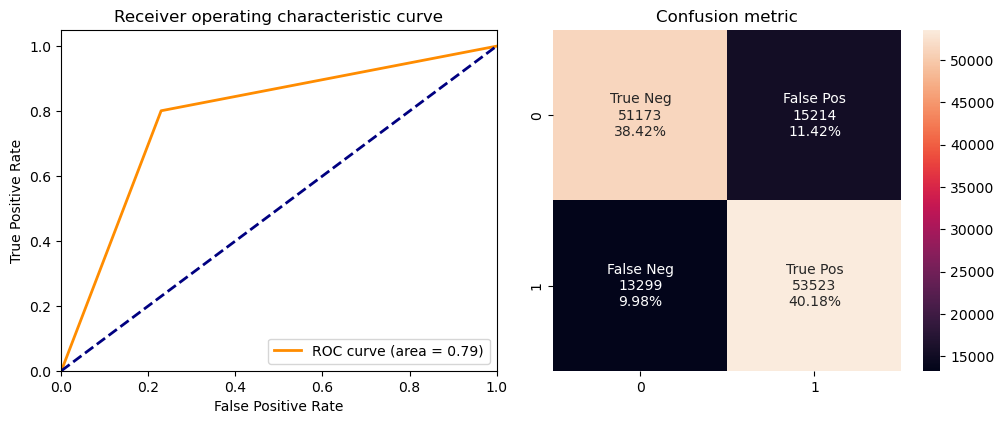

,Precision,Recall,F1,Accuracy,ROC AUC Score
0,0.78,0.8,0.79,0.79,0.79


In [13]:
from sklearn.linear_model import LogisticRegression

log_model = fittingModel("LogisticRegression" , LogisticRegression(),
                         X_train_basic, X_test_basic, y_train, y_test)

In [90]:
wrong_classified(X_test, y_test, log_model[1])

,text,label,prediction
378593,sitting wondering barbecue better quick countdown officially start wait,0,1
234331,found baby robin yardno mommie touch put woods hope finds cute opened mouth feed,0,1
1293940,tell us really feel going backforth sql compactfull mean data migration andor something else,1,0
235072,listened people ragging viola,0,1
1087348,want live vicariously,1,0
986044,go th floor official quiet floor,1,0
257760,wow laughing loud woke buahaha tears eyes difference lol cannot see background using itouch,0,1
948622,got work returned apartmentturned tv saw weather channel tell last,1,0
130547,google wave dev preview video firefox client crashed,0,1
325621,knw hv restrictions hey evryday quotlike alwaysquot inshalla spend like birthday may,0,1


# 2. NN

## Splitting into test and val

In [44]:
X = df['text']  # Features (text)
y = df['sentiment']  # Labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [59]:
 # X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### tokenization

In [47]:
textToken = [text.split() for text in X_train]

### creating embeeding model with wrod2vec

In [48]:
from gensim.models import Word2Vec
import gensim
import gensim.downloader as api

In [55]:
# WORD2VEC 
WORD2VEC_MODEL = "model.w2v"
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [50]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [51]:
w2v_model.build_vocab(textToken)

In [52]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 32581


In [53]:
%%time
w2v_model.train(textToken, total_examples=len(textToken), epochs=W2V_EPOCH)


CPU times: user 22min 59s, sys: 3.82 s, total: 23min 3s
Wall time: 4min 9s


(265615583, 304501536)

In [56]:
w2v_model.wv.most_similar("love")

[('adore', 0.628588080406189),
 ('loves', 0.5329499840736389),
 ('loved', 0.5313991904258728),
 ('looove', 0.5162301659584045),
 ('lovee', 0.5027317404747009),
 ('lt', 0.49240684509277344),
 ('loove', 0.48155686259269714),
 ('miss', 0.4778088927268982),
 ('loooove', 0.46292611956596375),
 ('looooove', 0.4417315125465393)]

In [58]:
w2v_model.save(WORD2VEC_MODEL)

#### Tokenizer

In [65]:
from keras.preprocessing.text import Tokenizer

2023-11-03 19:19:37.662668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 19:19:37.662710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 19:19:37.662740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 19:19:37.669721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 19:19:38.332123: W tensorflow/compiler/

In [66]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 364751
CPU times: user 12.7 s, sys: 87.9 ms, total: 12.8 s
Wall time: 12.8 s
